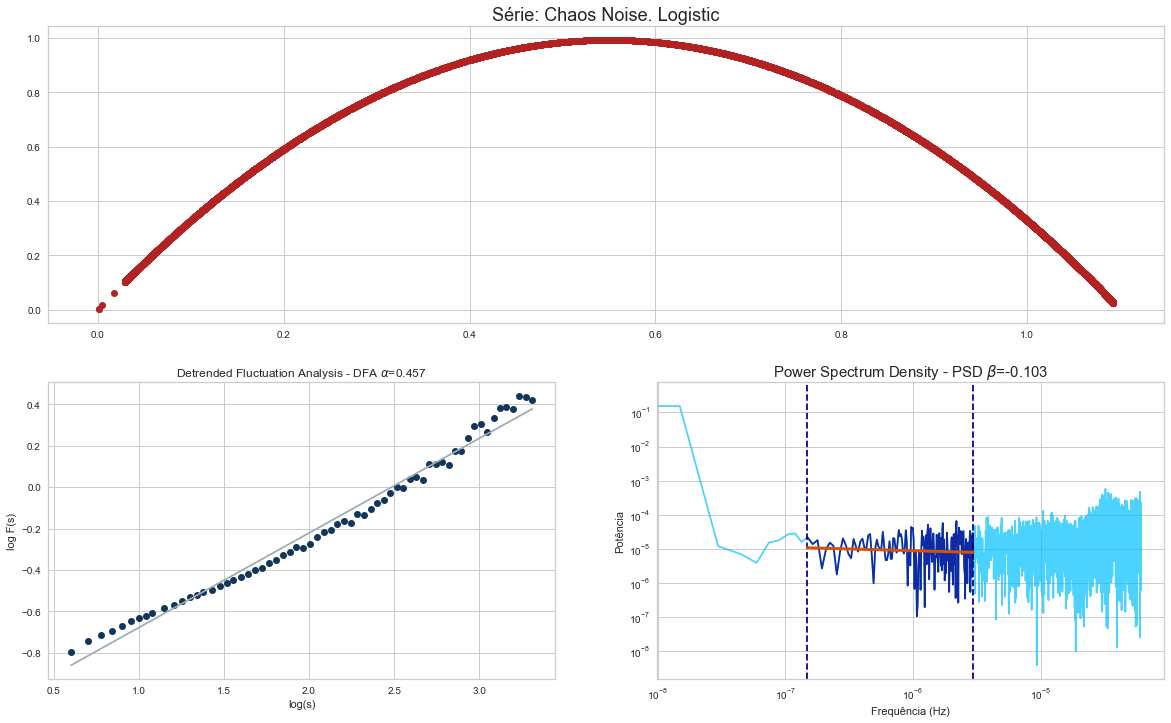

C:\Users\yurid\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:2552: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)


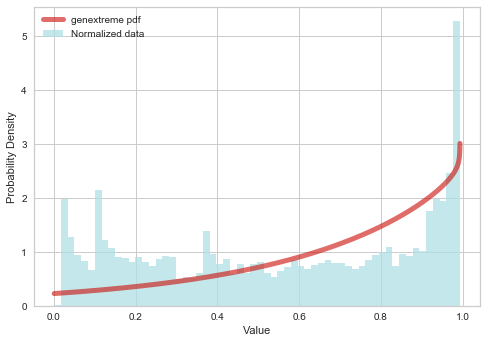

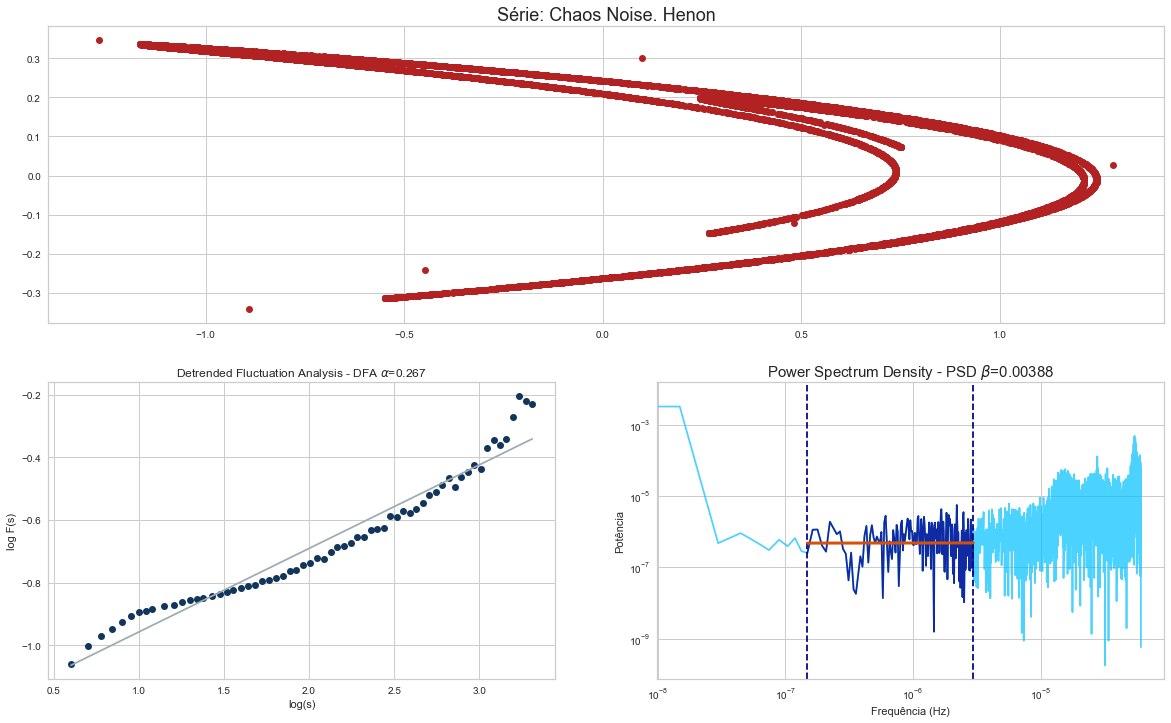

C:\Users\yurid\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:2552: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)


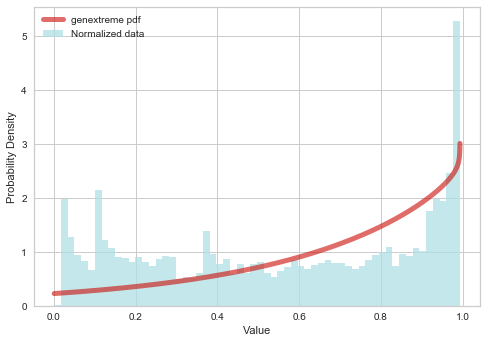

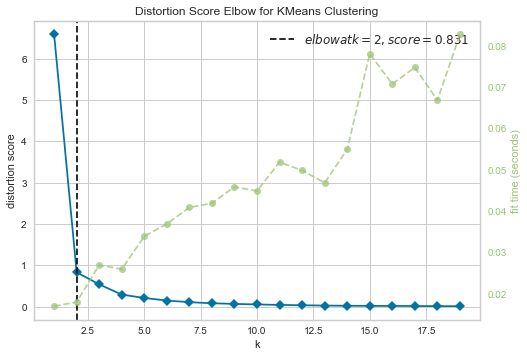

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


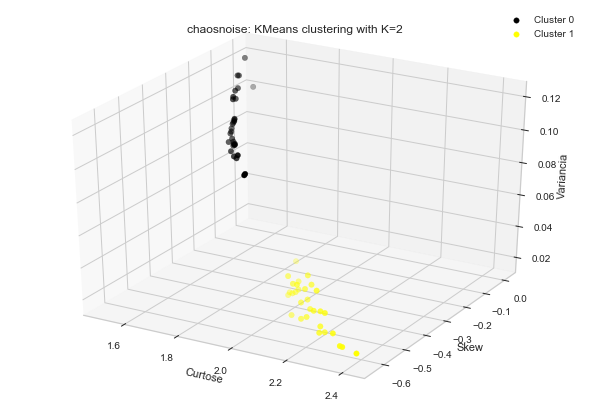

In [5]:
from scipy.stats import norm, genextreme
import numpy.random as rnd
from numpy.fft import rfftfreq, irfft
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Polygon
from yellowbrick.cluster import KElbowVisualizer
import mfdfa
import statsfuncs


def Logistic(dummy):
    N = 8192
    rho = 3.85 + 0.15 * np.random.uniform()
    tau = 1.1
    x = [0.001]
    y = [0.001]
    for i in range(1, N):
        y.append(tau * x[-1])
        x.append(rho * x[-1] * (1.0 - x[-1]))
    return y, x


def HenonMap(dummy):
    N = 8192
    a = 1.350 + 0.05 * np.random.uniform()
    b = 0.21 + 0.08 * np.random.uniform()
    x = [0.1]
    y = [0.3]
    for i in range(1, N):
        y.append(b * x[-1])
        x.append(y[-2] + 1.0 - a * x[-1] * x[-1])
    return x, y


def makeseries(func, iterationlist, amount):
    values = []
    ilist = []
    rawdata = []
    for i in iterationlist:
        for j in range(amount):
            x, y = func(i)
            alfa, xdfa, ydfa, reta = statsfuncs.dfa1d(y, 1)
            freqs, power, xdata, ydata, amp, index, powerlaw, INICIO, FIM = statsfuncs.psd(y)
            psi = mfdfa.makemfdfa(y)
            values.append(
                [statsfuncs.variance(y), statsfuncs.skewness(y), statsfuncs.kurtosis(y) + 3, alfa, index, psi])
            ilist.append(i)
        rawdata.append([i, x, y, alfa, xdfa, ydfa, reta, freqs, power, xdata, ydata, amp, index, powerlaw, INICIO, FIM])
    return values, ilist, rawdata


def makeK(d, ilist, title):
    d = np.array(d)
    kk = pd.DataFrame({'Variancia': d[:, 0], 'Skewness': d[:, 1], 'Curtose': d[:, 2]})
    K = 20
    model = KMeans()
    visualizer = KElbowVisualizer(model, k=(1, K))
    kIdx = visualizer.fit(kk)  
    visualizer.show()  
    kIdx = kIdx.elbow_value_
    model = KMeans(n_clusters=kIdx).fit(kk)

    fig = plt.figure()
    ax = Axes3D(fig)  
    cmap = plt.get_cmap('gnuplot')
    clr = [cmap(i) for i in np.linspace(0, 1, kIdx)]
    for i in range(0, kIdx):
        ind = (model.labels_ == i)
        ax.scatter(d[ind, 2], d[ind, 1], d[ind, 0], s=30, c=clr[i], label='Cluster %d' % i)

    ax.set_xlabel("Curtose")
    ax.set_ylabel("Skew")
    ax.set_zlabel("Variancia")
    plt.title(title + ': KMeans clustering with K=%d' % kIdx)
    plt.legend()
    plt.savefig(title + "clustersnoises.png")
    plt.show()
    d = pd.DataFrame({'Variancia': d[:, 0], 'Skewness': d[:, 1], 'Curtose': d[:, 2], 'Alpha': d[:, 3], 'Beta': d[:, 4],
                      "Psi": d[:, 5], "Cluster": model.labels_}, index=ilist)
    return d


def cullenfrey(xd, yd, legend, title):
    plt.figure(num=None, figsize=(8, 8), dpi=100, facecolor='w', edgecolor='k')
    fig, ax = plt.subplots()
    maior = max(xd)
    polyX1 = maior if maior > 4.4 else 4.4
    polyY1 = polyX1 + 1
    polyY2 = 3 / 2. * polyX1 + 3
    y_lim = polyY2 if polyY2 > 10 else 10

    x = [0, polyX1, polyX1, 0]
    y = [1, polyY1, polyY2, 3]
    scale = 1
    poly = Polygon(np.c_[x, y] * scale, facecolor='#1B9AAA', edgecolor='#1B9AAA', alpha=0.5)
    ax.add_patch(poly)
    ax.plot(xd, yd, marker="o", c="#e86a92", label=legend, linestyle='')
    ax.plot(0, 4.187999875999753, label="logistic", marker='+', c='black')
    ax.plot(0, 1.7962675925351856, label="uniform", marker='^', c='black')
    ax.plot(4, 9, label="exponential", marker='s', c='black')
    ax.plot(0, 3, label="normal", marker='*', c='black')
    ax.plot(np.arange(0, polyX1, 0.1), 3 / 2. * np.arange(0, polyX1, 0.1) + 3, label="gamma", linestyle='-', c='black')
    ax.plot(np.arange(0, polyX1, 0.1), 2 * np.arange(0, polyX1, 0.1) + 3, label="lognormal", linestyle='-.', c='black')
    ax.legend()
    ax.set_ylim(y_lim, 0)
    ax.set_xlim(-0.2, polyX1)
    plt.xlabel("Skewness²")
    plt.title(title + ": Cullen and Frey map")
    plt.ylabel("Kurtosis")
    plt.savefig(title + legend + "cullenfrey.png")
    plt.show()


def makespaces(s2, k, alpha, beta, legend, title):
    kk = pd.DataFrame({'Skew²': s2, 'Kurtosis': k, 'Alpha': alpha, 'Beta': beta})
    K = 8
    model = KMeans()
    visualizer = KElbowVisualizer(model, k=(1, K))
    kIdx = visualizer.fit(kk.drop(columns="Beta"))  
    visualizer.show() 
    kIdx = kIdx.elbow_value_
    model = KMeans(n_clusters=kIdx).fit(kk.drop(columns="Beta"))
    fig = plt.figure()
    ax = Axes3D(fig)
    cmap = plt.get_cmap('gnuplot')
    clr = [cmap(i) for i in np.linspace(0, 1, kIdx)]
    for i in range(0, kIdx):
        ind = (model.labels_ == i)
        ax.scatter(kk["Skew²"][ind], kk["Kurtosis"][ind], kk["Alpha"][ind], s=30, c=clr[i], label='Cluster %d' % i)
    ax.set_xlabel("Skew²")
    ax.set_ylabel("Kurtosis")
    ax.set_zlabel(r"$\alpha$")
    ax.legend()
    plt.title(title + ": EDF-K-means")
    plt.show()
    model = KMeans()
    visualizer = KElbowVisualizer(model, k=(1, K))
    kIdx = visualizer.fit(kk.drop(columns="Alpha"))  
    visualizer.show() 
    kIdx = kIdx.elbow_value_
    model = KMeans(n_clusters=kIdx).fit(kk.drop(columns="Alpha"))
    fig = plt.figure()
    ax = Axes3D(fig)
    cmap = plt.get_cmap('gnuplot')
    clr = [cmap(i) for i in np.linspace(0, 1, kIdx)]
    for i in range(0, kIdx):
        ind = (model.labels_ == i)
        ax.scatter(kk["Skew²"][ind], kk["Kurtosis"][ind], kk["Beta"][ind], s=30, c=clr[i], label='Cluster %d' % i)
    ax.set_xlabel("Skew²")
    ax.set_ylabel("Kurtosis")
    ax.set_zlabel(r"$\beta$")
    ax.legend()
    plt.title(title + ": EPSB-K-means")
    plt.show()


def makespaces62(s2, k, alpha, beta, legend, title, ilist):
    kk = pd.DataFrame({'Skew²': s2, 'Kurtosis': k, 'Alpha': alpha, 'Beta': beta, "Entity": ilist})
    K = 8
    model = KMeans()
    visualizer = KElbowVisualizer(model, k=(1, K))
    kIdx = visualizer.fit(kk.drop(columns=["Beta", "Entity"]))  
    visualizer.show() 
    kIdx = kIdx.elbow_value_
    model = KMeans(n_clusters=kIdx).fit(kk.drop(columns=["Beta", "Entity"]))
    print(len(model.labels_))
    fig = plt.figure(figsize=(20, 15))
    ax = Axes3D(fig)
    cmap = plt.get_cmap('gnuplot')
    ilist2 = list(set(ilist))
    clr = [cmap(i) for i in np.linspace(0, 1, len(ilist2))]
    for i in range(0, len(ilist2)):
        ind = (kk["Entity"] == ilist2[i])
        ax.scatter(kk["Skew²"][ind], kk["Kurtosis"][ind], kk["Alpha"][ind], s=30, c=clr[i], label=ilist2[i])
    ax.set_xlabel("Skew²")
    ax.set_ylabel("Kurtosis")
    ax.set_zlabel(r"$\alpha$")
    ax.legend()
    plt.title(title + ": EDF-K-means")
    plt.savefig("masoq.png")
    plt.show()
    kk = pd.DataFrame({'Skew²': s2, 'Kurtosis': k, 'Alpha': alpha, 'Beta': beta, "Entity": ilist}, index=model.labels_)
    kk.sort_index(inplace=True)
    kk.to_csv("clusteringalpha.csv")
    model = KMeans()
    visualizer = KElbowVisualizer(model, k=(1, K))
    kIdx = visualizer.fit(kk.drop(columns=["Alpha", "Entity"]))  
    visualizer.show() 
    kIdx = kIdx.elbow_value_
    model = KMeans(n_clusters=kIdx).fit(kk.drop(columns=["Alpha", "Entity"]))
    fig = plt.figure(figsize=(20, 15))
    ax = Axes3D(fig)
    cmap = plt.get_cmap('gnuplot')
    clr = [cmap(i) for i in np.linspace(0, 1, len(ilist2))]
    for i in range(0, len(ilist2)):
        ind = (kk["Entity"] == ilist2[i])
        ax.scatter(kk["Skew²"][ind], kk["Kurtosis"][ind], kk["Beta"][ind], s=30, c=clr[i], label=ilist[i])
    ax.set_xlabel("Skew²")
    ax.set_ylabel("Kurtosis")
    ax.set_zlabel(r"$\beta$")
    ax.legend()
    plt.title(title + ": EPSB-K-means")
    plt.savefig("masoq2.png")
    plt.show()
    kk = pd.DataFrame({'Skew²': s2, 'Kurtosis': k, 'Alpha': alpha, 'Beta': beta, "Entity": ilist}, index=model.labels_)
    kk.sort_index(inplace=True)
    kk.to_csv("clusteringbeta.csv")


def main():
    title = "Série: Chaos Noise. {0}"
    d, ilist, rawdata = makeseries(Logistic, ["Logistic"], 30)
    aux1, aux2, aux3 = makeseries(HenonMap, ["Henon"], 30)
    rawdata += aux3
    d += aux1
    ilist += aux2
    for i in range(len(rawdata)):
        plt.figure(figsize=(20, 12))
        # Plot da série temporal
        ax1 = plt.subplot(211)
        ax1.set_title(title.format(rawdata[i][0]), fontsize=18)
        ax1.plot(rawdata[i][1], rawdata[i][2], color="firebrick", marker='o', linestyle='')
        # Plot e cálculo do DFA
        ax2 = plt.subplot(223)
        ax2.set_title(r"Detrended Fluctuation Analysis - DFA $\alpha$={0:.3}".format(rawdata[i][3], fontsize=15))
        ax2.plot(rawdata[i][4], rawdata[i][5], marker='o', linestyle='', color="#12355B")
        ax2.plot(rawdata[i][4], rawdata[i][6], color="#9DACB2")
        # Plot e cálculo do PSD
        ax3 = plt.subplot(224)
        ax3.set_title(r"Power Spectrum Density - PSD $\beta$={0:.3}".format(rawdata[i][12]), fontsize=15)
        ax3.set_yscale('log')
        ax3.set_xscale('log')
        ax3.plot(rawdata[i][7], rawdata[i][8], '-', color='deepskyblue', alpha=0.7)
        ax3.plot(rawdata[i][9], rawdata[i][10], color="darkblue", alpha=0.8)
        ax3.axvline(rawdata[i][7][rawdata[i][14]], color="darkblue", linestyle='--')
        ax3.axvline(rawdata[i][7][rawdata[i][15]], color="darkblue", linestyle='--')
        ax3.plot(rawdata[i][9], rawdata[i][13](rawdata[i][9], rawdata[i][11], rawdata[i][12]), color="#D65108",
                 linestyle='-', linewidth=3, label='$%.4f$' % (rawdata[i][12]))
        ax2.set_xlabel("log(s)")
        ax2.set_ylabel("log F(s)")
        ax3.set_xlabel("Frequência (Hz)")
        ax3.set_ylabel("Potência")
        plt.savefig("Chaosserietemporalpsddfa{}.png".format(i))
        plt.show()
        
        n=8192
        ypoints=[min(rawdata[0][2]) + (i/n) * (max(rawdata[0][2])-min(rawdata[0][2])) for i in range(0, n+1)]
        gev_fit = genextreme.fit(rawdata[0][2])
        # GEV parameters from fit:
        c, loc, scale = gev_fit
        mean, var, skew, kurt = genextreme.stats(c, moments='mvsk')
        rv_gev = genextreme(c, loc=loc, scale=scale)
        
        gev_pdf = rv_gev.pdf(ypoints)
        #plt.title((title+"\nMu= {1:.3}, Sigma={2:.3}.").format(rawdata[i][0], mu, sigma))
        n, bins, patches = plt.hist(rawdata[0][2], 60, density=1, facecolor='powderblue', alpha=0.75, label="Normalized data")
        plt.plot(np.arange(min(bins), max(bins), (max(bins) - min(bins))/len(rawdata[0][2])), gev_pdf[:len(rawdata[0][2])],'r-', lw=5, alpha=0.6, label='genextreme pdf')
        plt.ylabel("Probability Density")
        plt.xlabel("Value")
        plt.legend()
        #plt.savefig("PDF"+filename.format(i))
        plt.show()
        
        '''
        (mu,sigma)=norm.fit(rawdata[i][2])
        plt.title((title+"\nMu= {1:.3}, Sigma={2:.3}.").format(rawdata[i][0], mu, sigma))
        n, bins, patches = plt.hist(rawdata[i][2], 60, density=1, facecolor='powderblue', alpha=0.75)
        plt.plot(bins,norm.pdf(bins,mu,sigma), c="black", linestyle='--')
        plt.savefig("colorednoise{}PDF.png".format(i))
        plt.show()
        plt.figure(figsize=(20, 12))
        '''
    title = "chaosnoise"
    d = makeK(d, ilist, title)


main()
    